# Drift detection on molecular graphs

## Methods

We illustrate drift detection on molecular graphs using a variety of detectors:

- [Kolmogorov-Smirnov detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/ksdrift.html) on the output of the binary classification [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826) to detect **prediction distribution shift**.

- [Model Uncertainty detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/modeluncdrift.html) which leverages a measure of uncertainty on the model predictions (in this case [MC dropout](https://arxiv.org/abs/1506.02142)) to detect drift which could lead to **degradation of model performance**.

- [Maximum Mean Discrepancy detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/mmddrift.html) on graph embeddings to flag **drift in the input data**.

- [Learned Kernel detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/learnedkerneldrift.html) which flags **drift in the input data** using a (deep) learned kernel. The method trains a (deep) kernel on part of the data to maximise an estimate of the test power. Once the kernel is learned a permutation test is performed in the usual way on the value of the Maximum Mean Discrepancy (MMD) on the held out test set.

- [Kolmogorov-Smirnov detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/ksdrift.html) to see if **drift** occurred **on graph level statistics** such as the number of nodes, edges and the average clustering coefficient.


## Dataset

We will train a classification model and detect drift on the *ogbg-molhiv* dataset. The dataset contains molecular graphs with both atom features (*atomic number-1, chirality, node degree, formal charge, number of H bonds, number of radical electrons, hybridization, aromatic?, in a ring?*) and bond level properties (*bond type (e.g. single or double), bond stereo code, conjugated?*). The goal is to predict whether a molecule inhibits HIV virus replication or not, so the task is binary classification. 

The dataset is split using the *scaffold splitting* procedure. This means that the molecules are split based on their 2D structural framework. Structurally different molecules are grouped into different subsets (train, validation, test) which could mean that there is drift between the splits.

The dataset is retrieved from the [Open Graph Benchmark](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) dataset collection.

## Dependencies

Besides `alibi-detect`, this example notebook also uses [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/stable/notes/installation.html) and [OGB](https://ogb.stanford.edu/docs/home/), both of which can be installed via pip/conda.

In [1]:
import numpy as np
import os
import torch

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed(0)

## Load and analyze data

In [2]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader

In [3]:
dataset_name = 'ogbg-molhiv'
batch_size = 32
dataset = PygGraphPropPredDataset(name=dataset_name)
split_idx = dataset.get_idx_split()

We set some samples apart to serve as the reference data for our drift detectors. Note that the allowed format of the reference data is very flexible and can be `np.ndarray` or `List[Any]`:

In [4]:
n_ref = 1000
n_h0 = 500

idx_tr = split_idx['train']
idx_sample = np.random.choice(idx_tr.numpy(), size=n_ref + n_h0, replace=False)
idx_ref, idx_h0 = idx_sample[:n_ref], idx_sample[n_ref:]
x_ref = [dataset[i] for i in idx_ref]
x_h0 = [dataset[i] for i in idx_h0]
idx_tr = torch.from_numpy(np.setdiff1d(idx_tr, idx_sample))
print(f'Number of reference instances: {len(x_ref)}')
print(f'Number of H0 instances: {len(x_h0)}')

Number of reference instances: 1000
Number of H0 instances: 500


In [5]:
dl_tr = DataLoader(dataset[idx_tr], batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset[split_idx['valid']], batch_size=batch_size, shuffle=False)
dl_te = DataLoader(dataset[split_idx['test']], batch_size=batch_size, shuffle=False)
print(f'Number of train, val and test batches: {len(dl_tr)}, {len(dl_val)} and {len(dl_te)}')

Number of train, val and test batches: 982, 129 and 129


In [6]:
ds = dataset
print()
print(f'Dataset: {ds}:')
print('=============================================================')
print(f'Number of graphs: {len(ds)}')
print(f'Number of node features: {ds.num_node_features}')
print(f'Number of edge features: {ds.num_edge_features}')
print(f'Number of classes: {ds.num_classes}')

i = 0
d = ds[i]

print(f'\nExample: {d}')
print('=============================================================')

print(f'Number of nodes: {d.num_nodes}')
print(f'Number of edges: {d.num_edges}')
print(f'Average node degree: {d.num_edges / d.num_nodes:.2f}')
print(f'Contains isolated nodes: {d.contains_isolated_nodes()}')
print(f'Contains self-loops: {d.contains_self_loops()}')
print(f'Is undirected: {d.is_undirected()}')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of node features: 9
Number of edge features: 3
Number of classes: 2

Example: Data(edge_attr=[40, 3], edge_index=[2, 40], x=[19, 9], y=[1, 1])
Number of nodes: 19
Number of edges: 40
Average node degree: 2.11
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Let's plot some graph summary statistics such as the distribution of the node degrees, number of nodes and edges as well as the clustering coefficients:

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.cluster import clustering
from torch_geometric.utils import degree, to_networkx
from tqdm import tqdm
from typing import Tuple


def degrees_and_clustering(loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    degrees, c_coeff, num_nodes, num_edges = [], [], [], []
    for data in tqdm(loader):
        row, col = data.edge_index
        deg = degree(row, data.x.size(0), dtype=data.x.dtype)
        degrees.append(deg.numpy())
        g = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)
        c = list(clustering(g).values())
        c_coeff.append(c)
        num_nodes += [d.num_nodes for d in data.to_data_list()]
        num_edges += [d.num_edges for d in data.to_data_list()]
    degrees = np.concatenate(degrees, axis=0)
    c_coeff = np.concatenate(c_coeff, axis=0)
    return degrees, c_coeff, np.array(num_nodes), np.array(num_edges)


# x: nodes, edges, degree, cluster
def plot_histogram(x: str, bins: int = None, log: bool = True) -> None:
    if x == 'nodes':
        vals = [num_nodes_tr, num_nodes_val, num_nodes_te]
    elif x == 'edges':
        vals = [num_edges_tr, num_edges_val, num_edges_te]
    elif x == 'degree':
        vals = [degree_tr, degree_val, degree_te]
    elif x == 'cluster':
        vals = [cluster_tr, cluster_val, cluster_te]
    labels = ['train', 'val', 'test']
    for v, l in zip(vals, labels):
        plt.hist(v, density=True, log=log, label=l, bins=bins)
    plt.title(f'{x} distribution')
    plt.legend()
    plt.show()

In [8]:
degree_tr, cluster_tr, num_nodes_tr, num_edges_tr = degrees_and_clustering(dl_tr)
degree_val, cluster_val, num_nodes_val, num_edges_val = degrees_and_clustering(dl_val)
degree_te, cluster_te, num_nodes_te, num_edges_te = degrees_and_clustering(dl_te)

100%|██████████| 129/129 [00:02<00:00, 48.92it/s]


In [9]:
print('Average number and stdev of nodes, edges, degree and clustering coefficients:')
print('\nTrain...')
print(f'Nodes: {num_nodes_tr.mean():.1f} +- {num_nodes_tr.std():.1f}')
print(f'Edges: {num_edges_tr.mean():.1f} +- {num_edges_tr.std():.1f}')
print(f'Degree: {degree_tr.mean():.1f} +- {degree_tr.std():.1f}')
print(f'Clustering: {cluster_tr.mean():.3f} +- {cluster_tr.std():.3f}')

print('\nValidation...')
print(f'Nodes: {num_nodes_val.mean():.1f} +- {num_nodes_val.std():.1f}')
print(f'Edges: {num_edges_val.mean():.1f} +- {num_edges_val.std():.1f}')
print(f'Degree: {degree_val.mean():.1f} +- {degree_val.std():.1f}')
print(f'Clustering: {cluster_val.mean():.3f} +- {cluster_val.std():.3f}')

print('\nTest...')
print(f'Nodes: {num_nodes_te.mean():.1f} +- {num_nodes_te.std():.1f}')
print(f'Edges: {num_edges_te.mean():.1f} +- {num_edges_te.std():.1f}')
print(f'Degree: {degree_te.mean():.1f} +- {degree_te.std():.1f}')
print(f'Clustering: {cluster_te.mean():.3f} +- {cluster_te.std():.3f}')

Average number and stdev of nodes, edges, degree and clustering coefficients:

Train...
Nodes: 25.3 +- 12.0
Edges: 54.1 +- 26.1
Degree: 2.1 +- 0.8
Clustering: 0.001 +- 0.028

Validation...
Nodes: 27.8 +- 12.8
Edges: 61.1 +- 27.8
Degree: 2.2 +- 0.8
Clustering: 0.003 +- 0.042

Test...
Nodes: 25.3 +- 12.5
Edges: 55.6 +- 27.1
Degree: 2.2 +- 0.7
Clustering: 0.004 +- 0.058


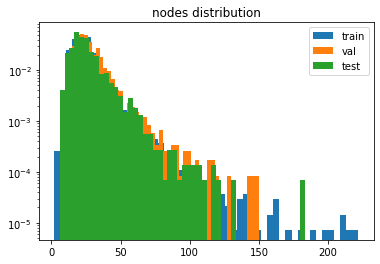

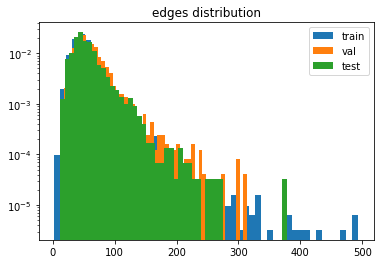

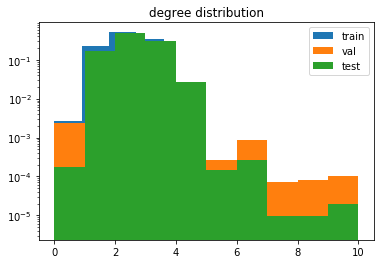

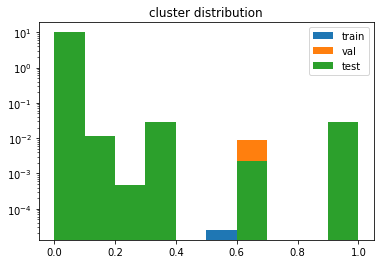

In [10]:
plot_histogram('nodes', bins=50)
plot_histogram('edges', bins=50)
plot_histogram('degree')
plot_histogram('cluster')

While the average number of nodes and edges are similar across the splits, the histograms show that the tails are slightly heavier for the training graphs.

## Plot molecules

We borrow code from the PyTorch Geometric [GNN explanation example](https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing#scrollTo=9Hh3YNASuYxm) to visualize molecules from the graph objects.

In [11]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P',
                'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'][0]]
        del data['x']
    return g

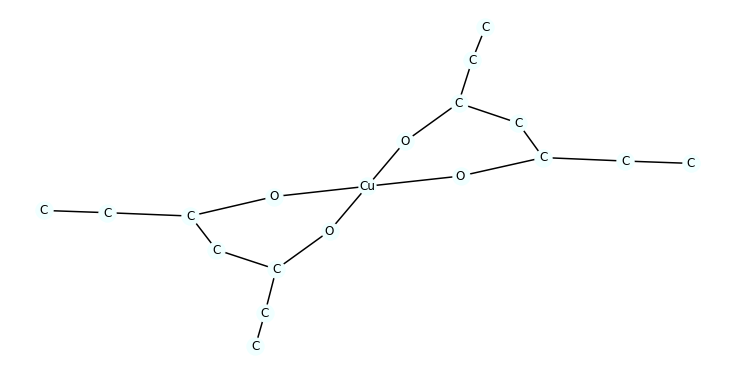

In [12]:
i = 0
mol = to_molecule(dataset[i])
plt.figure(figsize=(10, 5))
draw_molecule(mol)

## Train and evaluate a GNN classification model

As our classifier we use a variation of a [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826) incorporating edge (bond) as well as node (atom) features.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data.batch import Batch
from torch_geometric.nn import MessagePassing, global_add_pool, global_max_pool, global_mean_pool, LayerNorm
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class GINConv(MessagePassing):
    def __init__(self, emb_dim: int) -> None:
        super().__init__(aggr='add')
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2 * emb_dim),
            nn.BatchNorm1d(2 * emb_dim),
            nn.ReLU(),
            nn.Linear(2 * emb_dim, emb_dim)
        )
        self.eps = nn.Parameter(torch.Tensor([0.]))
        self.bond_encoder = BondEncoder(emb_dim=emb_dim)  # encode edge features

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        edge_emb = self.bond_encoder(edge_attr)
        return self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x, edge_attr=edge_emb))

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        return x_j + edge_attr

    def update(self, aggr_out: torch.Tensor) -> torch.Tensor:
        return aggr_out


class GIN(nn.Module):
    def __init__(self, n_layer: int = 5, emb_dim: int = 64, n_out: int = 2, dropout: float = .5,
                 jk: bool = True, residual: bool = True, pool: str = 'add', norm: str = 'batch') -> None:
        super().__init__()
        self.n_layer = n_layer
        self.jk = jk  # jumping-knowledge
        self.residual = residual  # residual/skip connections
        self.atom_encoder = AtomEncoder(emb_dim=emb_dim)  # encode node features
        self.convs = nn.ModuleList([GINConv(emb_dim) for _ in range(n_layer)])
        norm = nn.BatchNorm1d if norm == 'batch' else LayerNorm
        self.bns = nn.ModuleList([norm(emb_dim) for _ in range(n_layer)])
        if pool == 'mean':
            self.pool = global_mean_pool
        elif pool == 'add':
            self.pool = global_add_pool
        elif pool == 'max':
            self.pool = global_max_pool
        pool_dim = (n_layer + 1) * emb_dim if jk else emb_dim
        self.linear = nn.Linear(pool_dim, n_out)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, data: Batch) -> torch.Tensor:
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        # node embeddings
        hs = [self.atom_encoder(x)]
        for layer in range(self.n_layer):
            h = self.convs[layer](hs[layer], edge_index, edge_attr)
            h = self.bns[layer](h)
            if layer < self.n_layer - 1:
                h = F.relu(h)
            if self.residual:
                h += hs[layer]
            hs += [h]
        # graph embedding and prediction
        if self.jk:
            h = torch.cat([h for h in hs], -1)
        h_pool = self.pool(h, batch)
        h_drop = self.dropout(h_pool)
        h_out = self.linear(h_drop)
        return h_out

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

n_layer = 5
emb_dim = 300
n_out = 1
dropout = .5
jk = True
residual = False
pool = 'mean'
norm = 'batch'

model = GIN(n_layer, emb_dim, n_out, dropout, jk, residual, pool, norm).to(device)

device: cuda


Train and evaluate the model. Evaluation is done using [ROC-AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). If you already have a trained model saved, you can directly load it by specifying the `load_path`:

In [15]:
load_path = 'gnn'  # set to None if no pretrained model available

In [16]:
from ogb.graphproppred import Evaluator
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=.001)
evaluator = Evaluator(name=dataset_name)  # ROC-AUC for ogbg-molhiv


def train(loader: DataLoader, verbose: bool = False) -> None:
    dl = tqdm(loader, total=len(loader)) if verbose else loader
    model.train()
    for data in dl:
        data = data.to(device)
        optim.zero_grad()
        y_hat = model(data)
        is_labeled = data.y == data.y
        loss = criterion(y_hat[is_labeled], data.y[is_labeled].float())
        loss.backward()
        optim.step()
        if verbose:
            dl.set_postfix(dict(loss=loss.item()))


def evaluate(loader: DataLoader, split: str, verbose: bool = False) -> float:
    dl = tqdm(loader, total=len(loader)) if verbose else loader
    model.eval()
    y_pred, y_true = [], []
    for data in dl:
        data = data.to(device)
        with torch.no_grad():
            y_hat = model(data)
        y_pred.append(y_hat.cpu())
        y_true.append(data.y.float().cpu())
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    loss = criterion(y_pred, y_true)
    input_dict = dict(y_true=y_true, y_pred=y_pred)
    result_dict = evaluator.eval(input_dict)
    print(f'{split} ROC-AUC: {result_dict["rocauc"]:.3f} -- loss: {loss:.3f}')
    return result_dict["rocauc"]


if load_path is None or not os.path.isdir(load_path):
    epochs = 150
    rocauc_best = 0.
    save_path = 'gnn'
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1} / {epochs}')
        train(dl_tr)
        _ = evaluate(dl_tr, 'train')
        rocauc = evaluate(dl_val, 'val')
        if rocauc > rocauc_best and os.path.isdir(save_path):
            print('Saving new best model.')
            rocauc_best = rocauc
            torch.save(model.state_dict(), os.path.join(save_path, 'model.dict'))
        _ = evaluate(dl_te, 'test')
    load_path = save_path


# load (best) model
model.load_state_dict(torch.load(os.path.join(load_path, 'model.dict')))
_ = evaluate(dl_tr, 'train')
_ = evaluate(dl_val, 'val')
_ = evaluate(dl_te, 'test')

train ROC-AUC: 0.961 -- loss: 0.070
val ROC-AUC: 0.829 -- loss: 0.084
test ROC-AUC: 0.753 -- loss: 0.163


## Detect drift

### Prediction distribution drift

We will first detect drift on the prediction distribution of the GIN model. Since the binary classification model returns continuous numerical univariate predictions, we use the [Kolmogorov-Smirnov drift detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/ksdrift.html). First we define some utility functions:

In [17]:
from torch_geometric.data import Batch, Data
from typing import Dict, List, Union


labels = ['No!', 'Yes!']
def make_predictions(dd, xs: Dict[str, List[Data]]) -> None:
    for split, x in xs.items():
        preds = dd.predict(x)
        dl = DataLoader(x, batch_size=32, shuffle=False)
        _ = evaluate(dl, split)
        print('Drift? {}'.format(labels[preds['data']['is_drift']]))
        if isinstance(preds["data"]["p_val"], (list, np.ndarray)):
            print(f'p-value: {preds["data"]["p_val"]}')
        else:
            print(f'p-value: {preds["data"]["p_val"]:.3f}')
        print('')
        

def sample(split: str, n: int, ) -> List[Data]:
    idx = np.random.choice(split_idx[split].numpy(), size=n, replace=False)
    return [dataset[i] for i in idx]

Because we pass lists with `torch_geometric.data.Data` objects to the detector, we need to preprocess the data using the `batch_fn` into `torch_geometric.data.Batch` objects which can be fed to the model. Then we detect drift on the model prediction distribution.

In [18]:
from alibi_detect.cd import KSDrift
from alibi_detect.utils.pytorch import predict_batch
from functools import partial


def batch_fn(data: Union[List[Data], Batch]) -> Batch:
    if isinstance(data, Batch):
        return data
    else:
        return Batch().from_data_list(data)


preprocess_fn = partial(predict_batch, model=model, device=device, preprocess_fn=batch_fn, batch_size=32)
dd = KSDrift(x_ref, p_val=.05, preprocess_fn=preprocess_fn)

Since the dataset is heavily imbalanced, we will test the detectors on a sample which oversamples from the minority class (molecules which inhibit HIV virus replication):

In [19]:
split = 'test'
x_imb = sample(split, 500)
n = 0
for i in split_idx[split]:
    if dataset[i].y[0].item() == 1:
        x_imb.append(dataset[i])
        n += 1
print(f'# instances: {len(x_imb)} -- # class 1: {n}')

# instances: 630 -- # class 1: 130


In [20]:
xs = {'H0': x_h0, 'test sample': sample('test', 500), 'imbalanced sample': x_imb}
make_predictions(dd, xs)

H0 ROC-AUC: 0.763 -- loss: 0.208
Drift? No!
p-value: [0.84936297]

test sample ROC-AUC: 0.736 -- loss: 0.150
Drift? No!
p-value: [0.13626936]

imbalanced sample ROC-AUC: 0.749 -- loss: 0.940
Drift? Yes!
p-value: [4.5092685e-05]



As expected, prediction distribution shift is detected for the imbalanced sample but not for the random test sample with similar label distribution as the reference data.

### Prediction uncertainty drift

The [model uncertainty drift detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/modeluncdrift.html) can pick up when the model predictions drift into areas of changed uncertainty compared to the reference data. This can be a good proxy for drift which results in model performance degradation. The uncertainty is estimated via a Monte Carlo estimate ([MC dropout](https://arxiv.org/abs/1506.02142)). We use the [RegressorUncertaintyDrift detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/modeluncdrift.html) since our binary classification model returns 1D logits.

In [21]:
from alibi_detect.cd import RegressorUncertaintyDrift

dd = RegressorUncertaintyDrift(x_ref, model=model, backend='pytorch', p_val=.05, n_evals=100,
                               uncertainty_type='mc_dropout', preprocess_batch_fn=batch_fn)

In [22]:
make_predictions(dd, xs)

H0 ROC-AUC: 0.763 -- loss: 0.208
Drift? No!
p-value: [0.52494323]

test sample ROC-AUC: 0.736 -- loss: 0.150
Drift? Yes!
p-value: [0.]

imbalanced sample ROC-AUC: 0.749 -- loss: 0.940
Drift? Yes!
p-value: [0.]



Although we didn't pick up drift in the GIN model prediction distribution for the test sample, we can see that the model is less certain about the predictions on the test set, illustrated by the lower ROC-AUC.

### Input data drift using the MMD detector

We can also more detect drift on the input data by encoding the data with a randomly initialized GNN to extract graph embeddings. Then we apply our detector of choice, e.g. the [MMD detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/mmddrift.html) on the extracted embeddings.

In [23]:
class Encoder(nn.Module):
    def __init__(self, n_layer: int = 1, emb_dim: int = 64, jk: bool = True, 
                 residual: bool = True, pool: str = 'add', norm: str = 'batch') -> None:
        super().__init__()
        self.n_layer = n_layer
        self.jk = jk  # jumping-knowledge
        self.residual = residual  # residual/skip connections
        self.atom_encoder = AtomEncoder(emb_dim=emb_dim)  # encode node features
        self.convs = nn.ModuleList([GINConv(emb_dim) for _ in range(n_layer)])
        norm = nn.BatchNorm1d if norm == 'batch' else LayerNorm
        self.bns = nn.ModuleList([norm(emb_dim) for _ in range(n_layer)])
        self.pool = global_add_pool

    def forward(self, data: Batch) -> torch.Tensor:
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        # node embeddings
        hs = [self.atom_encoder(x)]
        for layer in range(self.n_layer):
            h = self.convs[layer](hs[layer], edge_index, edge_attr)
            h = self.bns[layer](h)
            if layer < self.n_layer - 1:
                h = F.relu(h)
            if self.residual:
                h += hs[layer]
            hs += [h]
        # graph embedding and prediction
        if self.jk:
            h = torch.cat([h for h in hs], -1)
        h_out = self.pool(h, batch)
        return h_out

In [24]:
from alibi_detect.cd import MMDDrift

enc = Encoder(n_layer=1).to(device)
preprocess_fn = partial(predict_batch, model=enc, device=device, preprocess_fn=batch_fn, batch_size=32)
dd = MMDDrift(x_ref, backend='pytorch', p_val=.05, n_permutations=1000, preprocess_fn=preprocess_fn)

In [25]:
make_predictions(dd, xs)

H0 ROC-AUC: 0.763 -- loss: 0.208
Drift? No!
p-value: 0.925

test sample ROC-AUC: 0.736 -- loss: 0.150
Drift? Yes!
p-value: 0.000

imbalanced sample ROC-AUC: 0.749 -- loss: 0.940
Drift? Yes!
p-value: 0.000



### Input data drift using a learned kernel

Instead of applying the MMD detector on the pooling output of a randomly initialized GNN encoder, we use the [Learned Kernel detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/learnedkerneldrift.html) which trains the encoder and kernel on part of the data to maximise an estimate of the detector's test power. Once the kernel is learned a permutation test is performed in the usual way on the value of the MMD on the held out test set.

In [26]:
from alibi_detect.cd import LearnedKernelDrift
from alibi_detect.utils.pytorch import DeepKernel

kernel = DeepKernel(enc, kernel_b=None)  # use the already defined random encoder in the deep kernel
dd = LearnedKernelDrift(x_ref, kernel, backend='pytorch', p_val=.05, dataloader=DataLoader, 
                        preprocess_batch_fn=batch_fn, epochs=2)

In [27]:
make_predictions(dd, xs)

H0 ROC-AUC: 0.763 -- loss: 0.208
Drift? No!
p-value: 0.630

test sample ROC-AUC: 0.736 -- loss: 0.150
Drift? Yes!
p-value: 0.000

imbalanced sample ROC-AUC: 0.749 -- loss: 0.940
Drift? Yes!
p-value: 0.000



Since the molecular scaffolds are different across the train, validation and test sets, we expect that this type of data shift is picked up in the input data (technically not the input but the graph embedding).

### Drift on graph statistics

We could also compute graph-level statistics such as the number of nodes, edges and clustering coefficient and detect drift on those statistics using the Kolmogorov-Smirnov test with multivariate correction (e.g. [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction)). First we define a preprocessing step to extract the summary statistics from the graphs:

In [28]:
# return number of nodes, edges and average clustering coefficient per graph
def graph_stats(data: List[Data]) -> np.ndarray:
    num_nodes = np.array([d.num_nodes for d in data])
    num_edges = np.array([d.num_edges for d in data])
    c = np.array([np.array(list(clustering(to_networkx(d)).values())).mean() for d in data])
    return np.concatenate([num_nodes[:, None], num_edges[:, None], c[:, None]], axis=-1)

In [29]:
dd = KSDrift(x_ref, p_val=.05, preprocess_fn=graph_stats)

In [30]:
make_predictions(dd, xs)

H0 ROC-AUC: 0.763 -- loss: 0.208
Drift? No!
p-value: [0.9884282  0.79581064 1.        ]

test sample ROC-AUC: 0.736 -- loss: 0.150
Drift? No!
p-value: [0.94992185 0.23822938 0.52494323]

imbalanced sample ROC-AUC: 0.749 -- loss: 0.940
Drift? Yes!
p-value: [5.1066105e-05 1.1882804e-05 9.5120013e-01]



The 3 returned p-values correspond to respectively the p-values for the number of nodes, edges and clustering coefficient. We already saw in the EDA that the distributions of the node, edge and clustering coefficients look similar across the train, validation and test sets except for the tails. This is confirmed by running the drift detector on the graph statistics which cannot seem to pick up on the differences in molecular scaffolds between the datasets, unless we heavily oversample from the minority class where the number of nodes and edges but not the clustering coefficient significantly differ.